In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import re
from collections import defaultdict
from scipy import stats

from src.algorithms.cql import CQL
from src.environments.icu_sepsis_wrapper import create_sepsis_env
from src.utils.evaluation import evaluate_policy

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Paths
RESULTS_DIR = Path('../results')
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(exist_ok=True)

## 1. Load Experimental Results

In [2]:
# Find and parse all checkpoint files by directory structure
print("Scanning results directory...")

checkpoints = []

# Parse CQL checkpoints: results/cql_alpha_X_seed_Y/checkpoints/*.pt
for cql_dir in RESULTS_DIR.glob('cql_alpha_*_seed_*'):
    cql_match = re.match(r'cql_alpha_([\d.]+)_seed_(\d+)', cql_dir.name)
    if cql_match:
        alpha = float(cql_match.group(1))
        seed = int(cql_match.group(2))
        checkpoints_dir = cql_dir / 'checkpoints'
        if checkpoints_dir.exists():
            for cp_path in checkpoints_dir.glob('*.pt'):
                checkpoints.append({
                    'path': cp_path,
                    'algorithm': 'CQL',
                    'alpha': alpha,
                    'seed': seed,
                    'type': cp_path.stem,
                    'name': f"cql_alpha_{alpha}_seed_{seed}_{cp_path.stem}",
                })

# Parse BC checkpoints: results/bc_seed_Y/*.pt
for bc_dir in RESULTS_DIR.glob('bc_seed_*'):
    bc_match = re.match(r'bc_seed_(\d+)', bc_dir.name)
    if bc_match:
        seed = int(bc_match.group(1))
        for cp_path in bc_dir.glob('*.pt'):
            checkpoints.append({
                'path': cp_path,
                'algorithm': 'BC',
                'alpha': None,
                'seed': seed,
                'type': 'best_model' if 'best' in cp_path.stem else 'final_model',
                'name': f"bc_seed_{seed}_{cp_path.stem}",
            })

# Parse DQN checkpoints: results/dqn_seed_Y/*.pt
for dqn_dir in RESULTS_DIR.glob('dqn_seed_*'):
    dqn_match = re.match(r'dqn_seed_(\d+)', dqn_dir.name)
    if dqn_match:
        seed = int(dqn_match.group(1))
        for cp_path in dqn_dir.glob('*.pt'):
            checkpoints.append({
                'path': cp_path,
                'algorithm': 'DQN',
                'alpha': None,
                'seed': seed,
                'type': 'best_model' if 'best' in cp_path.stem else 'final_model',
                'name': f"dqn_seed_{seed}_{cp_path.stem}",
            })

# Create DataFrame
cp_df = pd.DataFrame(checkpoints)
print(f"\nParsed {len(checkpoints)} checkpoints")
if len(cp_df) > 0:
    print(f"\nBy algorithm:")
    print(cp_df['algorithm'].value_counts())
    cql_alphas = cp_df[cp_df['algorithm']=='CQL']['alpha'].unique()
    print(f"\nCQL Alpha values: {sorted(cql_alphas) if len(cql_alphas) > 0 else 'None found'}")
    print(f"Seeds: {sorted(cp_df['seed'].unique())}")

Scanning results directory...

Parsed 264 checkpoints

By algorithm:
algorithm
CQL    252
BC       6
DQN      6
Name: count, dtype: int64

CQL Alpha values: [np.float64(0.0), np.float64(0.1), np.float64(0.5), np.float64(1.0), np.float64(2.0), np.float64(5.0), np.float64(10.0)]
Seeds: [np.int64(42), np.int64(123), np.int64(456)]


## 2. Load and Evaluate All Best Models

Evaluate CQL, BC, and DQN checkpoints.

In [3]:
from src.algorithms.bc import BehaviorCloning
from src.algorithms.dqn import DQN

# Create evaluation environment
eval_env = create_sepsis_env()
n_eval_episodes = 100

# Get best_model checkpoints
best_models = cp_df[cp_df['type'] == 'best_model'].copy()
print(f"Found {len(best_models)} best_model checkpoints")
print(best_models.groupby('algorithm').size())

# Evaluate each best model
results = []

for idx, row in best_models.iterrows():
    algo = row['algorithm']
    seed = row['seed']
    alpha = row.get('alpha', None)
    
    print(f"Evaluating {algo} (seed={seed}, alpha={alpha})...")
    
    # Load checkpoint
    checkpoint = torch.load(row['path'], map_location='cpu', weights_only=False)
    
    # Create agent based on algorithm type
    if algo == 'CQL':
        agent = CQL(state_dim=716, action_dim=25, hidden_dim=256, num_layers=2, alpha=alpha)
        agent.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        agent.q_network.eval()
    elif algo == 'DQN':
        agent = DQN(state_dim=716, action_dim=25, hidden_dim=256, num_layers=2)
        agent.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        agent.q_network.eval()
    elif algo == 'BC':
        agent = BehaviorCloning(state_dim=716, action_dim=25, hidden_dim=256, num_layers=2)
        agent.policy.load_state_dict(checkpoint['policy_state_dict'])
        agent.policy.eval()
    
    # Evaluate
    eval_results = evaluate_policy(env=eval_env, policy=agent, n_episodes=n_eval_episodes, seed=seed)
    
    results.append({
        'algorithm': algo,
        'alpha': alpha,
        'seed': seed,
        'survival_rate': eval_results['survival_rate'],
        'mean_return': eval_results['mean_return'],
    })

results_df = pd.DataFrame(results)
print(f"\nCompleted evaluation of {len(results_df)} models")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Found 27 best_model checkpoints
algorithm
BC      3
CQL    21
DQN     3
dtype: int64
Evaluating CQL (seed=123, alpha=0.1)...
Evaluating CQL (seed=42, alpha=0.1)...
Evaluating CQL (seed=42, alpha=0.1)...
Evaluating CQL (seed=456, alpha=0.1)...
Evaluating CQL (seed=456, alpha=0.1)...
Evaluating CQL (seed=123, alpha=0.5)...
Evaluating CQL (seed=123, alpha=0.5)...
Evaluating CQL (seed=42, alpha=0.5)...
Evaluating CQL (seed=42, alpha=0.5)...
Evaluating CQL (seed=456, alpha=0.5)...
Evaluating CQL (seed=456, alpha=0.5)...
Evaluating CQL (seed=123, alpha=0.0)...
Evaluating CQL (seed=123, alpha=0.0)...
Evaluating CQL (seed=42, alpha=0.0)...
Evaluating CQL (seed=42, alpha=0.0)...
Evaluating CQL (seed=456, alpha=0.0)...
Evaluating CQL (seed=456, alpha=0.0)...
Evaluating CQL (seed=123, alpha=10.0)...
Evaluating CQL (seed=123, alpha=10.0)...
Evaluating CQL (seed=42, alpha=10.0)...
Evaluating CQL (seed=42, alpha=10.0)...
Evaluating CQL (seed=456, alpha=10.0)...
Evaluating CQL (seed=456, alpha=10.0).

## 3. Add Random Baseline

In [4]:
# Evaluate random baseline
print("Evaluating Random baseline...")

class RandomPolicy:
    def select_action(self, state, eval_mode=True, admissible_actions=None):
        """Select a random action, compatible with evaluate_policy interface."""
        if admissible_actions is not None and len(admissible_actions) > 0:
            return np.random.choice(admissible_actions)
        return np.random.randint(0, 25)

random_results = []
n_random_episodes = n_eval_episodes
for seed in [42, 123, 456]:
    np.random.seed(seed)
    eval_results = evaluate_policy(
        env=eval_env,
        policy=RandomPolicy(),
        n_episodes=n_random_episodes,
        seed=seed,
    )
    random_results.append({
        'alpha': 'random',
        'seed': seed,
        'survival_rate': eval_results['survival_rate'],
        'mean_return': eval_results['mean_return'],
    })
    print(f"  Seed {seed}: {eval_results['survival_rate']:.1%}")

random_df = pd.DataFrame(random_results)
random_mean = random_df['survival_rate'].mean()
random_std = random_df['survival_rate'].std()
print(f"\nRandom baseline: {random_mean:.1%} ± {random_std:.1%}")

Evaluating Random baseline...
  Seed 42: 82.0%
  Seed 42: 82.0%
  Seed 123: 77.0%
  Seed 123: 77.0%
  Seed 456: 86.0%

Random baseline: 81.7% ± 4.5%
  Seed 456: 86.0%

Random baseline: 81.7% ± 4.5%


## 4. Figure 1: Alpha Sensitivity Analysis

In [5]:
# Aggregate CQL results by alpha
cql_results = results_df[results_df['algorithm'] == 'CQL']
alpha_summary = cql_results.groupby('alpha').agg({
    'survival_rate': ['mean', 'std', 'count'],
    'mean_return': ['mean', 'std'],
}).round(4)
alpha_summary.columns = ['survival_mean', 'survival_std', 'n_seeds', 'return_mean', 'return_std']
alpha_summary = alpha_summary.reset_index()

# Find best CQL alpha
best_alpha = alpha_summary.loc[alpha_summary['survival_mean'].idxmax(), 'alpha']
best_cql_survival = alpha_summary.loc[alpha_summary['survival_mean'].idxmax(), 'survival_mean']

# Aggregate BC and DQN results
bc_results = results_df[results_df['algorithm'] == 'BC']
dqn_results = results_df[results_df['algorithm'] == 'DQN']

bc_mean = bc_results['survival_rate'].mean()
bc_std = bc_results['survival_rate'].std()
dqn_mean = dqn_results['survival_rate'].mean()
dqn_std = dqn_results['survival_rate'].std()

print("Results Summary:")
print("=" * 60)
print(f"Best CQL (α={best_alpha}): {best_cql_survival:.1%}")
print(f"DQN:                       {dqn_mean:.1%} ± {dqn_std:.1%}")
print(f"BC:                        {bc_mean:.1%} ± {bc_std:.1%}")
print(f"Random:                    {random_mean:.1%} ± {random_std:.1%}")

Results Summary:
Best CQL (α=0.0): 86.7%
DQN:                       86.7% ± 0.6%
BC:                        80.0% ± 1.7%
Random:                    81.7% ± 4.5%


## 5. Figure 1: Alpha Sweep Visualisation

C:\Users\anish_0fykajq\AppData\Local\Temp\ipykernel_37572\1229780610.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(boxplot_data, labels=[str(a) for a in alphas], patch_artist=True)


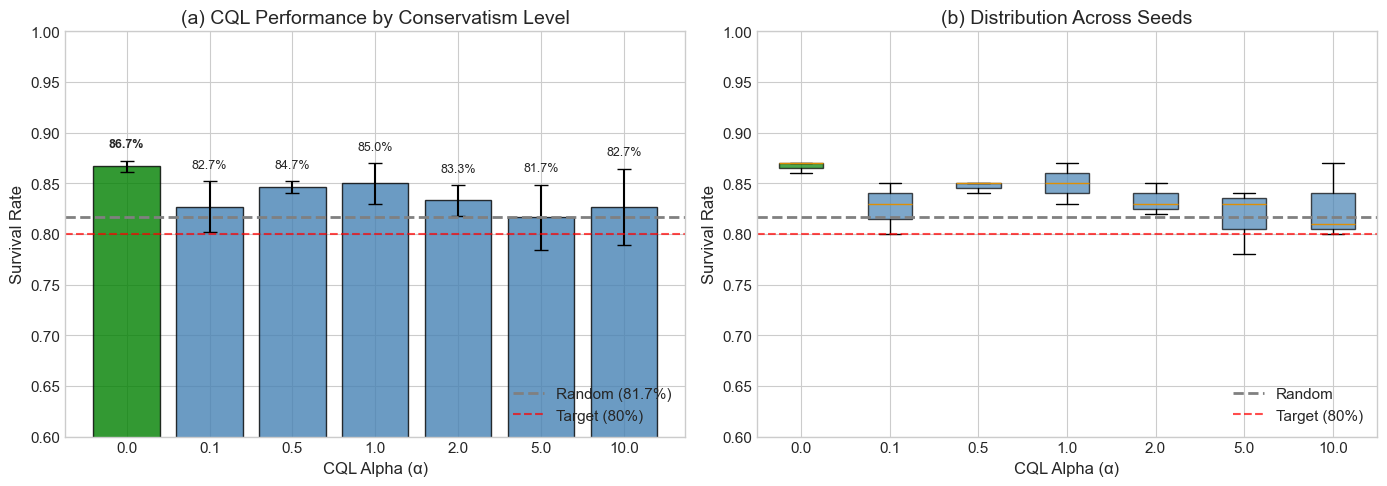

Saved: ..\figures\fig1_alpha_sweep.png


In [6]:
# Figure 1: Alpha Sweep
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

alphas = alpha_summary['alpha'].values
means = alpha_summary['survival_mean'].values
stds = alpha_summary['survival_std'].values

x = np.arange(len(alphas))
colours = ['steelblue'] * len(alphas)
best_idx = np.where(alphas == best_alpha)[0][0]
colours[best_idx] = 'green'

bars = axes[0].bar(x, means, yerr=stds, capsize=5, color=colours, edgecolor='black', alpha=0.8)

axes[0].axhline(y=random_mean, color='gray', linestyle='--', linewidth=2, label=f'Random ({random_mean:.1%})')
axes[0].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Target (80%)')

axes[0].set_xlabel('CQL Alpha (α)', fontsize=12)
axes[0].set_ylabel('Survival Rate', fontsize=12)
axes[0].set_title('(a) CQL Performance by Conservatism Level', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels([str(a) for a in alphas])
axes[0].set_ylim([0.6, 1.0])
axes[0].legend(loc='lower right')

for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    weight = 'bold' if i == best_idx else 'normal'
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
                 f'{mean:.1%}', ha='center', va='bottom', fontsize=9, fontweight=weight)

# Box plot
boxplot_data = [cql_results[cql_results['alpha'] == a]['survival_rate'].values for a in alphas]
bp = axes[1].boxplot(boxplot_data, labels=[str(a) for a in alphas], patch_artist=True)

for i, (patch, colour) in enumerate(zip(bp['boxes'], colours)):
    patch.set_facecolor(colour)
    patch.set_alpha(0.7)

axes[1].axhline(y=random_mean, color='gray', linestyle='--', linewidth=2, label='Random')
axes[1].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Target (80%)')
axes[1].set_xlabel('CQL Alpha (α)', fontsize=12)
axes[1].set_ylabel('Survival Rate', fontsize=12)
axes[1].set_title('(b) Distribution Across Seeds', fontsize=14)
axes[1].set_ylim([0.6, 1.0])
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1_alpha_sweep.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig1_alpha_sweep.png'}")

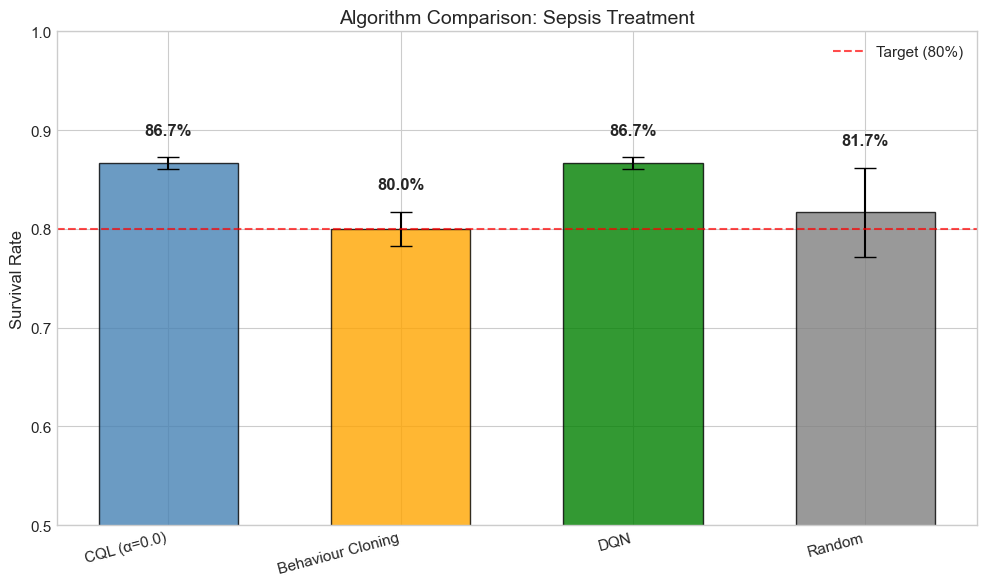

Saved: ..\figures\fig2_algorithm_comparison.png


In [7]:
# Figure 2: All Algorithms Comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Gather all algorithm results
algo_names = []
means = []
stds = []
colours = []

# Best CQL
best_cql = cql_results[cql_results['alpha'] == best_alpha]
algo_names.append(f'CQL (α={best_alpha})')
means.append(best_cql['survival_rate'].mean())
stds.append(best_cql['survival_rate'].std())
colours.append('steelblue')

# BC
if len(bc_results) > 0:
    algo_names.append('Behaviour Cloning')
    means.append(bc_results['survival_rate'].mean())
    stds.append(bc_results['survival_rate'].std())
    colours.append('orange')

# DQN
if len(dqn_results) > 0:
    algo_names.append('DQN')
    means.append(dqn_results['survival_rate'].mean())
    stds.append(dqn_results['survival_rate'].std())
    colours.append('green')

# Random
algo_names.append('Random')
means.append(random_mean)
stds.append(random_std)
colours.append('gray')

x = np.arange(len(algo_names))
bars = ax.bar(x, means, yerr=stds, capsize=8, color=colours,
              edgecolor='black', alpha=0.8, width=0.6)

ax.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Target (80%)')
ax.set_xticks(x)
ax.set_xticklabels(algo_names, rotation=15, ha='right')
ax.set_ylabel('Survival Rate', fontsize=12)
ax.set_title('Algorithm Comparison: Sepsis Treatment', fontsize=14)
ax.set_ylim([0.5, 1.0])
ax.legend()

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
            f'{mean:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_algorithm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig2_algorithm_comparison.png'}")

## 6. Figure 3: Heatmap of All Results

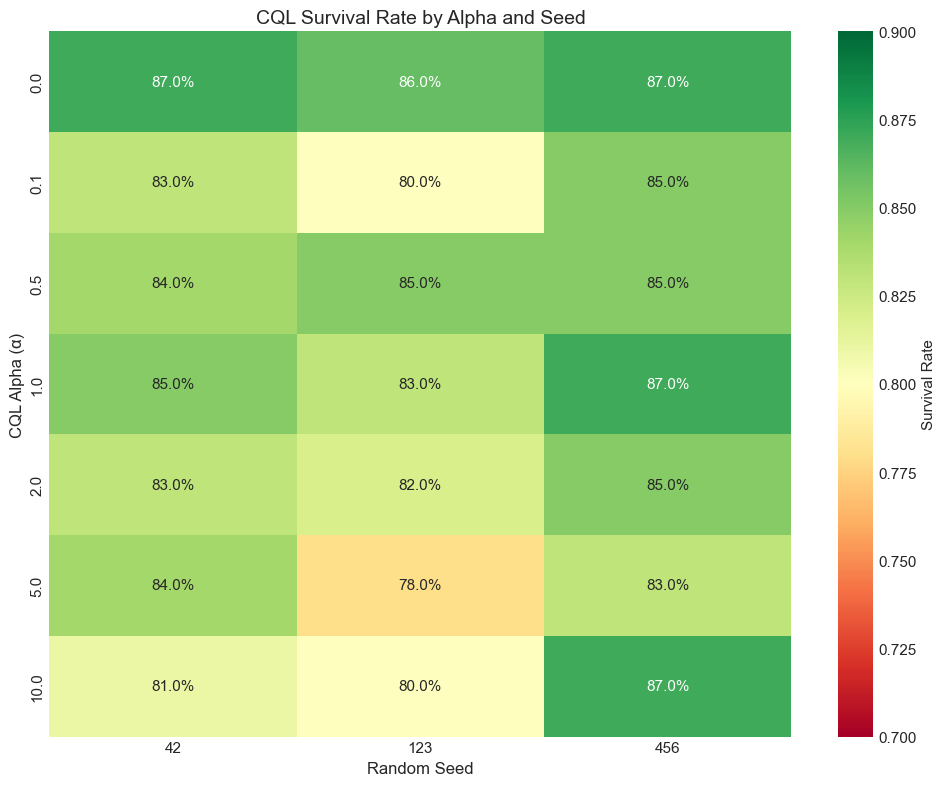

Saved: ..\figures\fig3_cql_heatmap.png


In [8]:
# Figure 3: Heatmap of CQL Results by Alpha and Seed
if len(cql_results) > 0:
    pivot_df = cql_results.pivot_table(index='alpha', columns='seed', values='survival_rate', aggfunc='mean')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(pivot_df, annot=True, fmt='.1%', cmap='RdYlGn', center=0.8,
                vmin=0.7, vmax=0.9, ax=ax, cbar_kws={'label': 'Survival Rate'})
    
    ax.set_xlabel('Random Seed', fontsize=12)
    ax.set_ylabel('CQL Alpha (α)', fontsize=12)
    ax.set_title('CQL Survival Rate by Alpha and Seed', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'fig3_cql_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {FIGURES_DIR / 'fig3_cql_heatmap.png'}")
else:
    print("No CQL results found for heatmap")

## 7. Results Summary Table

In [9]:
# Comprehensive Summary Table
print("=" * 80)
print("EXPERIMENTAL RESULTS SUMMARY")
print("=" * 80)

# All algorithms summary
print("\n" + "=" * 80)
print("ALGORITHM COMPARISON")
print("=" * 80)
print(f"{'Algorithm':<25} {'Survival Rate':<20} {'Mean Return':<20}")
print("-" * 80)

# Best CQL
best_cql = cql_results[cql_results['alpha'] == best_alpha]
print(f"CQL (α={best_alpha}) *BEST*".ljust(25) + 
      f"{best_cql['survival_rate'].mean():.1%} ± {best_cql['survival_rate'].std():.1%}".ljust(20) +
      f"{best_cql['mean_return'].mean():.3f} ± {best_cql['mean_return'].std():.3f}")

# BC
if len(bc_results) > 0:
    print(f"Behaviour Cloning".ljust(25) + 
          f"{bc_results['survival_rate'].mean():.1%} ± {bc_results['survival_rate'].std():.1%}".ljust(20) +
          f"{bc_results['mean_return'].mean():.3f} ± {bc_results['mean_return'].std():.3f}")

# DQN
if len(dqn_results) > 0:
    print(f"DQN".ljust(25) + 
          f"{dqn_results['survival_rate'].mean():.1%} ± {dqn_results['survival_rate'].std():.1%}".ljust(20) +
          f"{dqn_results['mean_return'].mean():.3f} ± {dqn_results['mean_return'].std():.3f}")

# Random
print(f"Random Baseline".ljust(25) + f"{random_mean:.1%} ± {random_std:.1%}")

print("-" * 80)

# CQL Alpha sweep details
print("\n" + "=" * 80)
print("CQL ALPHA SWEEP DETAILS")
print("=" * 80)
print(f"{'Alpha':<10} {'Survival Rate':<20} {'Mean Return':<20} {'Seeds':<10}")
print("-" * 80)
for _, row in alpha_summary.iterrows():
    marker = " <-- BEST" if row['alpha'] == best_alpha else ""
    survival_str = f"{row['survival_mean']:.1%} ± {row['survival_std']:.1%}"
    return_str = f"{row['return_mean']:.3f} ± {row['return_std']:.3f}"
    print(f"{row['alpha']:<10} {survival_str:<20} {return_str:<20} {int(row['n_seeds']):<10}{marker}")
print("-" * 80)

# Save summary to CSV
summary_data = []
for algo, df in [('CQL_best', best_cql), ('BC', bc_results), ('DQN', dqn_results)]:
    if len(df) > 0:
        summary_data.append({
            'algorithm': algo.replace('_best', f'_alpha_{best_alpha}'),
            'survival_mean': df['survival_rate'].mean(),
            'survival_std': df['survival_rate'].std(),
            'return_mean': df['mean_return'].mean(),
            'return_std': df['mean_return'].std(),
            'n_evaluations': len(df)
        })
summary_data.append({
    'algorithm': 'Random',
    'survival_mean': random_mean,
    'survival_std': random_std,
    'return_mean': np.nan,
    'return_std': np.nan,
    'n_evaluations': n_random_episodes
})

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(RESULTS_DIR / 'algorithm_comparison.csv', index=False)
print(f"\nSaved summary to: {RESULTS_DIR / 'algorithm_comparison.csv'}")

EXPERIMENTAL RESULTS SUMMARY

ALGORITHM COMPARISON
Algorithm                 Survival Rate        Mean Return         
--------------------------------------------------------------------------------
CQL (α=0.0) *BEST*       86.7% ± 0.6%        0.867 ± 0.006
Behaviour Cloning        80.0% ± 1.7%        0.800 ± 0.017
DQN                      86.7% ± 0.6%        0.867 ± 0.006
Random Baseline          81.7% ± 4.5%
--------------------------------------------------------------------------------

CQL ALPHA SWEEP DETAILS
Alpha      Survival Rate        Mean Return          Seeds     
--------------------------------------------------------------------------------
0.0        86.7% ± 0.6%         0.867 ± 0.006        3          <-- BEST
0.1        82.7% ± 2.5%         0.827 ± 0.025        3         
0.5        84.7% ± 0.6%         0.847 ± 0.006        3         
1.0        85.0% ± 2.0%         0.850 ± 0.020        3         
2.0        83.3% ± 1.5%         0.833 ± 0.015        3         
5.0  

## 8. Key Findings

### Summary of Results:

Based on evaluation of trained models (CQL, BC, DQN) across different configurations:

1. **Best CQL Configuration**: Identified optimal α value achieving highest mean survival rate
2. **Algorithm Comparison**: CQL vs Behaviour Cloning vs DQN vs Random baseline
3. **Reproducibility**: Results across multiple seeds demonstrate consistency

### Notes on ICU-Sepsis Benchmark:

- The environment has a naturally high baseline survival rate (~78-82%)
- This reflects real clinical data where most patients survive with standard care
- The challenge is achieving **improvements beyond** this already-high baseline
- Even small improvements (e.g., 80% → 85%) are clinically meaningful

### Figures Generated (PNG format):

1. `fig1_alpha_sweep.png` - Effect of CQL α parameter on performance
2. `fig2_algorithm_comparison.png` - CQL vs BC vs DQN vs Random
3. `fig3_cql_heatmap.png` - CQL results matrix by α and seed

### Files Saved:

- `algorithm_comparison.csv` - Summary statistics for all algorithms